In [2]:
import os
import shutil

# Set paths
source_dir = r"F:\VIT\AI\BreaKHis_v1\histology_slides\breast"
target_dir = r"F:\VIT\AI\BreaKHis_v1\flatimg"

# Create target directories for flat structure
benign_flat_dir = os.path.join(target_dir, 'Benign')
malignant_flat_dir = os.path.join(target_dir, 'Malignant')
os.makedirs(benign_flat_dir, exist_ok=True)
os.makedirs(malignant_flat_dir, exist_ok=True)

# Function to recursively copy images to a flat directory
def flatten_directory_structure(source, target):
    for root, dirs, files in os.walk(source):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust for image file extensions
                source_file = os.path.join(root, file)
                shutil.copy(source_file, target)

# Flatten Benign structure
flatten_directory_structure(os.path.join(source_dir, 'Benign'), benign_flat_dir)

# Flatten Malignant structure
flatten_directory_structure(os.path.join(source_dir, 'Malignant'), malignant_flat_dir)

print("Flattening complete.")


Flattening complete.


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set paths to the flattened dataset
base_dir = r'F:\VIT\AI\BreaKHis_v1\flatimg'  # Replace with your path
benign_dir = os.path.join(base_dir, 'Benign')
malignant_dir = os.path.join(base_dir, 'Malignant')

# Destination directories for train, validation, and test splits
train_dir = r'F:\VIT\AI\BreaKHis_v1\flatimg\split\train/'
val_dir = r'F:\VIT\AI\BreaKHis_v1\flatimg\split\validate/'
test_dir = r'F:\VIT\AI\BreaKHis_v1\flatimg\split\test/'

# Create the target directories
for category in ['Benign', 'Malignant']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Function to split and copy images
def split_and_copy_images(source_dir, category, train_dest, val_dest, test_dest, train_ratio=0.7, val_ratio=0.2):
    # List all image files
    all_images = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Split data into training and temp (val + test)
    train_images, temp_images = train_test_split(all_images, test_size=1 - train_ratio, random_state=42)
    
    # Further split temp into validation and test
    val_images, test_images = train_test_split(temp_images, test_size=(1 - train_ratio - val_ratio) / (1 - train_ratio), random_state=42)
    
    # Copy files to respective directories
    for img in train_images:
        shutil.copy(img, os.path.join(train_dest, category))
    for img in val_images:
        shutil.copy(img, os.path.join(val_dest, category))
    for img in test_images:
        shutil.copy(img, os.path.join(test_dest, category))

# Split and copy images for both categories
split_and_copy_images(benign_dir, 'Benign', train_dir, val_dir, test_dir)
split_and_copy_images(malignant_dir, 'Malignant', train_dir, val_dir, test_dir)

print("Data split into train, validate, and test sets.")


Data split into train, validate, and test sets.


In [7]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.chdir(r"F:\VIT\AI\BreaKHis_v1\flatimg\split")

# Paths
base_dir = r'F:\VIT\AI\BreaKHis_v1\flatimg\split'  # Replace with your actual path
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Image preprocessing parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

# Data generators with augmentation for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load ResNet50 model pre-trained on ImageNet, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Fine-tuning: unfreeze the base model and re-train with a lower learning rate
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again for fine-tuning
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")



Found 4428 images belonging to 2 classes.
Found 1107 images belonging to 2 classes.


94765736/94765736 [==============================] - 101s 1us/step
Epoch 1/20


138/138 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.6754
Epoch 1: val_loss improved from inf to 0.62214, saving model to best_model.h5


D:\Ishaan\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - 202s 1s/step - loss: 0.6496 - accuracy: 0.6754 - val_loss: 0.6221 - val_accuracy: 0.6847
Epoch 2/20
138/138 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6881
Epoch 2: val_loss did not improve from 0.62214
138/138 [==============================] - 196s 1s/step - loss: 0.6212 - accuracy: 0.6881 - val_loss: 0.6442 - val_accuracy: 0.6866
Epoch 3/20
138/138 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.6897
Epoch 3: val_loss did not improve from 0.62214
138/138 [==============================] - 197s 1s/step - loss: 0.6209 - accuracy: 0.6897 - val_loss: 0.6525 - val_accuracy: 0.6875
Epoch 4/20
138/138 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6906
Epoch 4: val_loss did not improve from 0.62214
138/138 [==============================] - 202s 1s/step - loss: 0.6147 - accuracy: 0.6906 - val_loss: 0.6266 - val_accuracy: 0.6838
Epoch 5/20
138/138 [=======================

25/25 [==============================] - 35s 1s/step


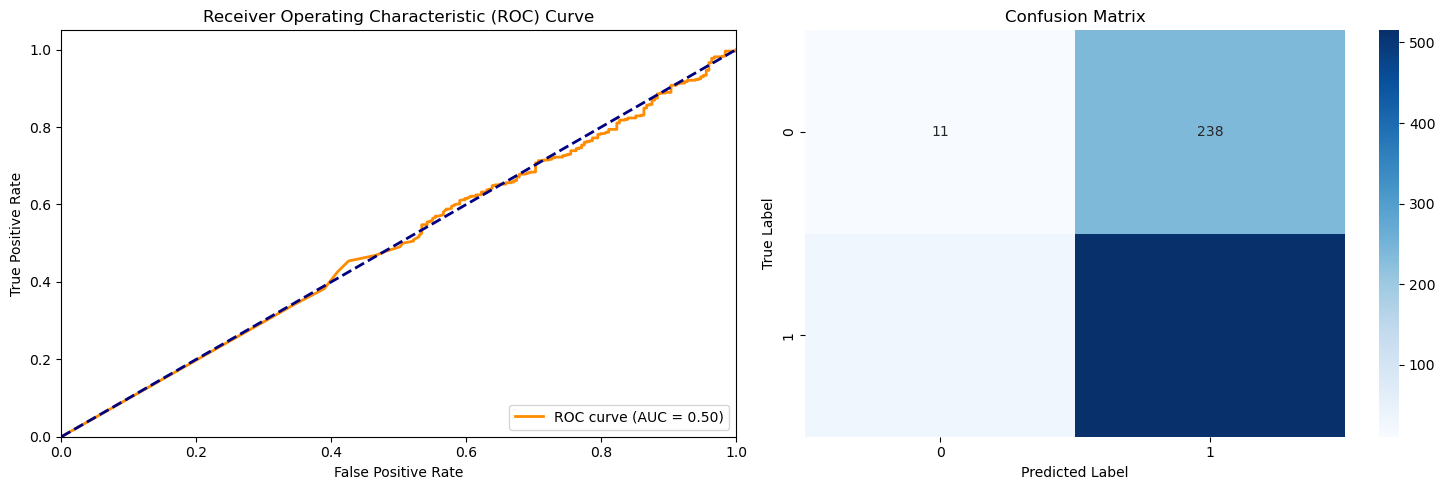


Detailed Classification Report:
Accuracy: 0.6633
Precision: 0.6839
Recall: 0.9467
F1-Score: 0.7941


In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

def evaluate_model(model, test_generator):
    # Get predictions
    predictions = model.predict(test_generator)
    # Get true labels
    true_labels = test_generator.labels
    
    # Calculate metrics
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    # Convert predictions to binary (0 or 1)
    pred_labels = (predictions > 0.5).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Get classification report
    report = classification_report(true_labels, pred_labels, output_dict=True)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Plot ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Plot confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Classification Report:")
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall: {report['1']['recall']:.4f}")
    print(f"F1-Score: {report['1']['f1-score']:.4f}")
    
    return {
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'report': report
    }

# If you're using the model you just trained:
results = evaluate_model(model, test_generator)

# If you're loading a saved model:
# model = load_model('best_model.h5')
# results = evaluate_model(model, test_generator)

In [9]:
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.chdir(r"F:\VIT\AI\BreaKHis_v1\flatimg\split")

# Paths
base_dir = r'F:\VIT\AI\BreaKHis_v1\flatimg\split'  # Replace with your actual path
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Image preprocessing parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

# Data generators with augmentation for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load VGG16 model pre-trained on ImageNet, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
vggmodel = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vggmodel.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model_vgg16.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
vggmodel.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Fine-tuning: unfreeze the base model and re-train with a lower learning rate
base_model.trainable = True
vggmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train again for fine-tuning
vggmodel.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Found 4428 images belonging to 2 classes.
Found 1107 images belonging to 2 classes.
58889256/58889256 [==============================] - 154s 3us/step
Epoch 1/20
138/138 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.7327
Epoch 1: val_loss improved from inf to 0.69676, saving model to best_model_vgg16.h5
138/138 [==============================] - 397s 3s/step - loss: 0.5305 - accuracy: 0.7327 - val_loss: 0.6968 - val_accuracy: 0.6829
Epoch 2/20


D:\Ishaan\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


138/138 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8141
Epoch 2: val_loss did not improve from 0.69676
138/138 [==============================] - 343s 2s/step - loss: 0.4178 - accuracy: 0.8141 - val_loss: 0.7634 - val_accuracy: 0.6811
Epoch 3/20
138/138 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8490
Epoch 3: val_loss did not improve from 0.69676
138/138 [==============================] - 335s 2s/step - loss: 0.3616 - accuracy: 0.8490 - val_loss: 0.7506 - val_accuracy: 0.6765
Epoch 4/20
138/138 [==============================] - ETA: 0s - loss: 0.3594 - accuracy: 0.8435
Epoch 4: val_loss improved from 0.69676 to 0.67807, saving model to best_model_vgg16.h5
138/138 [==============================] - 332s 2s/step - loss: 0.3594 - accuracy: 0.8435 - val_loss: 0.6781 - val_accuracy: 0.6949
Epoch 5/20
138/138 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.8594
Epoch 5: val_loss did not improve from 0.67807
13